# Notebook 1 : Apprentissage supervisé

Le DataSet utilisé est accessible à l'adresse : https://www.kaggle.com/lava18/google-play-store-apps.

ZINOPOULOS-YANNOPOULOS Florian

AZOUI Rayane

## Partie 1 - Description du problème

Nous allons nous mettre dans la peau d'un entrepreneur souhaitant lancer une application sur le Google Play Store à des fins commerciales. Afin d'améliorer les chances de succès de notre application, nous devons étudier les tendances et les attentes des consommateurs.

Ainsi à partir de l'étude des données de notre dataset, nous souhaitons répondre aux questions suivantes :

    1. Quelles catégories d'application ont le plus de téléchargements ?
    2. Quels critères parmi ces applications font qu'elles obtiennent une note supérieure ou égale à 4 ?
    3. Quel est le meilleur prix à faire payer pour notre application ?

Nous avons choisi cette problématique car il nous semblait intéressant d'essayer de mettre en oeuvre les notions que nous avons apprises ce semestre afin de résoudre un problème réaliste : celui d'une étude de marché.

## Partie 2 - Modèle

Ce notebook va faire intervenir les notions d'apprentissage supervisé et de résolution de problèmes de classification.

Le but de notre étude va être d'essayer de mettre en avant des caractéristiques des applications qui ont du succès. Après avoir trouvé ces caractéristiques, pour vérifier leur pertinence, nous allons utiliser un classifieur ADALINE qui aura appris sur le dataset utilisé afin de prédire la note qui sera probablement attribuée à notre application (qui sera un vecteur avec toutes les "bonnes" caractéristiques que nous aurons trouvées).

Notre classifieur ADALINE à un unique hyperparamètre $\epsilon$ dont nous allons déterminer la valeur optimale lors de l'apprentissage en utilisant la validation croisée. Nous allons faire varier les valeurs de $\epsilon$, utiliser la validation croisée, puis voir quelle valeur de $\epsilon$ donne la meilleure précision et une variance satisfaisante.

## Partie 3 - Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import re
from iads import Classifiers as cl
from iads import utils as ut
import graphviz as gv
%matplotlib inline 

Le jeu de données qui nous intéresse particulièrement ici est celui fourni dans googleplaystore.csv : il fournit les caractéristiques de l'application et, en particulier, la note attribuée à celle-ci.

In [2]:
gp_store = pd.read_csv("GoogleApps/googleplaystore.csv")

### A) Découverte du dataset

In [3]:
cols = list(gp_store.columns.values)
print(cols)
print("Nombre de descripteurs d'une donnée : %d " % len(cols))

['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver']
Nombre de descripteurs d'une donnée : 13 


In [4]:
gp_store.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

In [5]:
print("Nombre d'entrées du dataset : ", len(gp_store))

Nombre d'entrées du dataset :  10841


In [6]:
gp_store.head(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Nous avons déjà les informations suivantes :

* Une donnée du dataset est décrite par 13 attributs.
* Parmi ces attributs, seule la note est encodée sous une forme numérique, les autres sont représentés par des chaînes de caractères.
* Nous avons initialement 10841 entrées dans notre dataset.

** Mais toutes ces données sont-elles exploitables ? Tous les attributs nous sont-ils utiles ? **

### B) Filtrage du dataset

Commençons à nous intéresser aux attributs qui ne nous seront pas utiles ici.

* En premier lieu, l'attribut 'App' donnant le nom  de l'application ne nous est pas nécessaire (quoique pour être pointilleux on pourrait s'intéresser à la longueur optimale de ce nom et aux lettres les plus fréquentes dans les noms des applications à succès...).

* Ensuite le type 'Genres' fait un peu redite avec l'attribut 'Category', il n'apporte pas toujours une information supplémentaire vis à vis de celui-ci en outre.

* On choisit de ne pas traiter la version de l'application et la version minimale d'Android requise. Cependant dans une étude plus approfondie, ces attributs pourraient être utiles pour essayer de déduire quelle version d'Android est la plus répandue ou bien pour voir si la maintenance régulière d'une application est gage de son succès.

* On supprime l'attribut installs, il ne nous semble pas très logique d'essayer de prédire les valeurs des paramètres optimaux pour notre application en disant qu'il faut que celle-ci ait tant de téléchargements. Cela reviendrait par exemple à dire qu'il faut qu'elle ait du succès pour avoir du succès...

In [7]:
gp_store.drop('App', inplace=True, axis=1)
gp_store.drop('Last Updated', inplace=True, axis=1)
gp_store.drop('Current Ver', inplace=True, axis=1)
gp_store.drop('Genres', inplace=True, axis=1)
gp_store.drop('Android Ver', inplace=True, axis=1)
gp_store.drop('Installs', inplace=True, axis=1)
gp_store.head(5)

,Category,Rating,Reviews,Size,Type,Price,Content Rating
0,ART_AND_DESIGN,4.1,159,19M,Free,0,Everyone
1,ART_AND_DESIGN,3.9,967,14M,Free,0,Everyone
2,ART_AND_DESIGN,4.7,87510,8.7M,Free,0,Everyone
3,ART_AND_DESIGN,4.5,215644,25M,Free,0,Teen
4,ART_AND_DESIGN,4.3,967,2.8M,Free,0,Everyone


Nous allons vérifier s'il existe des valeurs NaN dans certaines entrées et si c'est le cas, nous filtrerons le dataset pour ne retenir que les données qui sont complètes. 

Ensuite, une fois ce premier filtrage effectué, nous vérifierons qu'aucune donnée ne contient de valeurs erronées (exemple: une erreur a lieu lors du scrapping et les valeurs données dans les attributs ne correspondent pas à l'attribut qu'ils décrivent). Dans ce cas, nous ferons un second filtrage. 

Enfin, nous nous assurerons qu'il n'y a aucun doublon parmi les données (ce qui pourrait être dommageable pour l'apprentissage de notre classifieur).

In [8]:
# Détection des données incomplètes
print("Avant filtrage")
haveNaN = gp_store[gp_store.isna().any(axis=1)]
print("%d entrées possèdent au moins une valeur NaN\n" % len(haveNaN))

# Premier filtrage du dataset
print("Après filtrage")
gp_store = gp_store.dropna()
print("Il y a à présent : %d entrées" % len(gp_store))

Avant filtrage
1475 entrées possèdent au moins une valeur NaN

Après filtrage
Il y a à présent : 9366 entrées


In [9]:
# Vérification de la présence de valeurs erronées

for col in gp_store.columns:
    types = []
    vals = np.unique(gp_store[col].values)
    types.append(type(vals[0]))
    for i in range (1, len(vals)):
        if type(vals[i]) != types[0]:
            types.append(type(vals[i]))
    if len(types) != 1:
        print("Problème colonne :", col)
        print("types = ", types)
    else:
        print("Colonne " + col + " : OK !\n")

Colonne Category : OK !

Colonne Rating : OK !

Colonne Reviews : OK !

Colonne Size : OK !

Colonne Type : OK !

Colonne Price : OK !

Colonne Content Rating : OK !



Nous allons malgré tout faire un set de tests supplémentaires (visuels ou logiques) pour nous assurer qu'aucune erreur ne nous a échappé.

Les tests sont tous commentés et les résultats sont indiqués à côté de ceux-ci.

In [10]:
# print(np.unique(gp_store["Category"]))        # Vérification visuelle : OK !
# print(np.unique(gp_store["Rating"]))          # Vérification visuelle : OK !

#reviews = np.unique(gp_store["Reviews"])
#for val in reviews:                            # Vérification : OK !
    #try:
        #int(val)
    #except ValueError:
        #print(val)
#print("Terminé")

#sizes = np.unique(gp_store['Size'])            # Vérification : OK !
#for val in sizes:
    #if "k" not in val and "M" not in val and val != "Varies with device":
        #print(val)

#installs = np.unique(gp_store['Installs'])     # Vérification : OK !
#for val in installs:
    #if "+" not in val:
        #print(val)

#print(np.unique(gp_store['Type']))             # Vérification visuelle : OK !

#prices = np.unique(gp_store['Price'])          # Vérification : OK !
#for val in prices:
    #if "$" not in val and val != '0':
        #print(val)

#print(np.unique(gp_store['Content Rating']))   # Vérification visuelle : OK

#print(np.unique(gp_store['Genres']))           # Vérification visuelle : OK !

#updates = np.unique(gp_store['Last Updated'])  # Vérification : OK !
#for val in updates:
    #res = re.search("([a-zA-Z]+\s)([0-9]{1,2}[,]\s)[0-9]{4}", val)
    #if res:
        #continue
    #else:
        #print(val)

print("Terminé")

Terminé


In [11]:
# Suppression des éventuels doublons

oldDataset = gp_store.copy()
gp_store = gp_store.drop_duplicates()
print("Suppression de %d doublons" % (len(oldDataset) - len(gp_store)))
print("Il y a à présent %d données" % len(gp_store))

Suppression de 480 doublons
Il y a à présent 8886 données


POUR RÉSUMER : 

* 1475 entrées incomplètes ont été supprimées.
* Aucune erreur de valeur d'attribut n'a été trouvée.
* 479 doublons ont été supprimés.

=> On travaille à présent sur 8887 entrées.

### C) Adaptation des données

Le classifieur ADALINE est un classifieur fonctionnant avec des données numériques uniquement. Or la plupart de nos attributs sont représentés sous forme de chaînes de caractères et, de plus, nous avons des attributs catégoriels.

Nous allons faire les traitements suivants:

* L'attribut catégoriel 'Category' va être transformé en attribut numérique grâce au 'One-Hot Encoding'.

* 'Rating' sera converti en entiers.

* Les chaînes de caractères représentant le nombre de commentaires ne vont pas être converties en entiers. Leur valeur est trop grande et produit des overflow lors des calculs. Nous allons plutôt les diviser en 5 catégories, puis utiliser le 'One-Hot Encoding' sur ces valeurs.

* Les entrées de 'Size' vont être converties en flottants, avec pour valeur le poids de l'application converti en Méga-octets. Les applications pesant moins d'un Mo seront considérées comme pesant 1Mo.

* Nous allons utiliser le 'One-Hot Encoding' sur 'Type' et 'Content-Rating'

* 'Price' sera converti en flottants.

In [12]:
# Pareil que précédemment mais regroupé pour pouvoir facilement réinitialiser

gp_store = pd.read_csv("GoogleApps/googleplaystore.csv")
gp_store.drop('App', inplace=True, axis=1)
gp_store.drop('Last Updated', inplace=True, axis=1)
gp_store.drop('Current Ver', inplace=True, axis=1)
gp_store.drop('Genres', inplace=True, axis=1)
gp_store.drop('Android Ver', inplace=True, axis=1)
gp_store.drop('Installs', inplace=True, axis=1)
gp_store = gp_store.dropna()
gp_store = gp_store.drop_duplicates()

In [13]:
# Adaptation de Reviews

gp_store["Reviews"] = gp_store["Reviews"].astype(int)
l1 = gp_store.index[gp_store['Reviews'] < 1000].tolist()
l2 = gp_store.index[(gp_store['Reviews'] < 10000) & (gp_store['Reviews'] >= 1000)].tolist()
l3 = gp_store.index[(gp_store['Reviews'] < 100000) & (gp_store['Reviews'] >= 10000)].tolist()
l4 = gp_store.index[(gp_store['Reviews'] < 1000000) & (gp_store['Reviews'] >= 100000)].tolist()
l5 = gp_store.index[gp_store['Reviews'] >= 1000000].tolist()

for i in l1:
    gp_store.loc[i, 'Reviews'] = "1000-"
for i in l2:
    gp_store.loc[i, 'Reviews'] = "10000-"
for i in l3:
    gp_store.loc[i, 'Reviews'] = "100000-"
for i in l4:
    gp_store.loc[i, 'Reviews'] = "1000000-"
for i in l5:
    gp_store.loc[i, 'Reviews'] = "1000000+"

In [14]:
# One-hot Encoding sur Category, Type, Content-Rating, Installs et Reviews

dummies = pd.get_dummies(gp_store.Reviews, prefix="Rev")
gp_store = gp_store.join(dummies)
gp_store.drop('Reviews', inplace=True, axis=1)

dummies = pd.get_dummies(gp_store.Category, prefix="Cat")
gp_store = gp_store.join(dummies)
gp_store.drop('Category', inplace=True, axis=1)

dummies = pd.get_dummies(gp_store.Type, prefix="Type")
gp_store = gp_store.join(dummies)
gp_store.drop('Type', inplace=True, axis=1)

dummies = pd.get_dummies(gp_store['Content Rating'], prefix="Cont_Rat")
gp_store = gp_store.join(dummies)
gp_store.drop('Content Rating', inplace=True, axis=1)

gp_store.head(5)

,Rating,Size,Price,Rev_1000-,Rev_10000-,Rev_100000-,Rev_1000000+,Rev_1000000-,Cat_ART_AND_DESIGN,Cat_AUTO_AND_VEHICLES,...,Cat_VIDEO_PLAYERS,Cat_WEATHER,Type_Free,Type_Paid,Cont_Rat_Adults only 18+,Cont_Rat_Everyone,Cont_Rat_Everyone 10+,Cont_Rat_Mature 17+,Cont_Rat_Teen,Cont_Rat_Unrated
0,4.1,19M,0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
1,3.9,14M,0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
2,4.7,8.7M,0,0,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
3,4.5,25M,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0
4,4.3,2.8M,0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0


In [15]:
# Transformation de la colonne Size
index = gp_store.index.tolist()
for i in index:
    if (gp_store.loc[i, "Size"] == "Varies with device"):
        gp_store.loc[i, "Size"] = "0"
    elif ("k" in gp_store.loc[i, "Size"]):
        gp_store.loc[i, "Size"] = "1"
    else:
        val = gp_store.loc[i, "Size"]
        val = re.search("[0-9]+[.]*[0-9]*", val)
        val = float(val.string.split("M")[0])
        gp_store.loc[i, "Size"] = str(val)

gp_store["Size"] = gp_store["Size"].astype(float)

# Transformation de la colonne Price

for i in index:
    val = gp_store.loc[i, 'Price']
    if (val == '0'):
        continue
    val = re.search("[$]{1}[0-9]+[.]*[0-9]*", val)
    val = float(val.string.split("$")[1])
    gp_store.loc[i, "Price"] = str(val)
gp_store["Price"] = gp_store["Price"].astype(float)


gp_store.head(20)

,Rating,Size,Price,Rev_1000-,Rev_10000-,Rev_100000-,Rev_1000000+,Rev_1000000-,Cat_ART_AND_DESIGN,Cat_AUTO_AND_VEHICLES,...,Cat_VIDEO_PLAYERS,Cat_WEATHER,Type_Free,Type_Paid,Cont_Rat_Adults only 18+,Cont_Rat_Everyone,Cont_Rat_Everyone 10+,Cont_Rat_Mature 17+,Cont_Rat_Teen,Cont_Rat_Unrated
0,4.1,19.0,0.0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
1,3.9,14.0,0.0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
2,4.7,8.7,0.0,0,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
3,4.5,25.0,0.0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0
4,4.3,2.8,0.0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
5,4.4,5.6,0.0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
6,3.8,19.0,0.0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
7,4.1,29.0,0.0,0,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
8,4.4,33.0,0.0,0,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
9,4.7,3.1,0.0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0


In [16]:
for i in index:
    rating = gp_store.loc[i, "Rating"]
    if (rating >= 4):
        gp_store.loc[i, "Rating"] = 1
    else:
        gp_store.loc[i, "Rating"] = -1

gp_store.head(5)

,Rating,Size,Price,Rev_1000-,Rev_10000-,Rev_100000-,Rev_1000000+,Rev_1000000-,Cat_ART_AND_DESIGN,Cat_AUTO_AND_VEHICLES,...,Cat_VIDEO_PLAYERS,Cat_WEATHER,Type_Free,Type_Paid,Cont_Rat_Adults only 18+,Cont_Rat_Everyone,Cont_Rat_Everyone 10+,Cont_Rat_Mature 17+,Cont_Rat_Teen,Cont_Rat_Unrated
0,1.0,19.0,0.0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
1,-1.0,14.0,0.0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
2,1.0,8.7,0.0,0,0,1,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
3,1.0,25.0,0.0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0
4,1.0,2.8,0.0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0


## Partie 4 - Protocole expérimental

En premier lieu, nous allons essayer de déterminer quelles catégories d'applications sont le plus téléchargées.

Ensuite, en prenant uniquement les catégories trouvées dans l'expérience précédente, on essaiera de trouver les particularités qui font qu'on obtient une note supérieure à 4.5 étoiles (donc plus de 4 étoiles).

Enfin, nous allons déterminer l'impact du prix sur le nombre de téléchargements pour s'assurer d'avoir le bon prix.


Pour vérifier nos résultats, comme expliqué précédemment, nous allons entraîner un classifieur sur les données. Ensuite, nous allons créer des vecteurs correspondant aux applications avec les "bons critères" trouvés dans les expériences précédentes. Nous allons alors faire prédire à notre classifieur si les notes obtenues par ces applications sont au moins de 4 étoiles.


## Partie 5 - Résultats

### A) Génération d'un dataset plus adapté à l'étude avec histogrammes

Le dataset traité dans la partie 3 est pratique pour travailler avec des classifieurs mais rend la génération d'histogrammes plus compliquée. On va générer un deuxième dataset destiné à générer des histogrammes en reprenant en partie le code de la partie 3.

In [17]:
gp_store_his = pd.read_csv("GoogleApps/googleplaystore.csv")
gp_store_his.drop('App', inplace=True, axis=1)
gp_store_his.drop('Last Updated', inplace=True, axis=1)
gp_store_his.drop('Current Ver', inplace=True, axis=1)
gp_store_his.drop('Genres', inplace=True, axis=1)
gp_store_his.drop('Android Ver', inplace=True, axis=1)
gp_store_his = gp_store_his.dropna()
gp_store_his = gp_store_his.drop_duplicates()

Les attributs Installs, Size, Reviews, Price sont problématiques car ils comportent beaucoup de valeurs différentes. Pour régler ce problème, nous allons regrouper ces valeurs en différentes catégories, ce qui rendra les histogrammes plus lisibles.

In [18]:
# On regroupe les valeurs de Reviews en 5 catégories
gp_store_his["Reviews"] = gp_store_his["Reviews"].astype(int)
l1 = gp_store_his.index[gp_store_his['Reviews'] < 1000].tolist()
l2 = gp_store_his.index[(gp_store_his['Reviews'] < 10000) & (gp_store_his['Reviews'] >= 1000)].tolist()
l3 = gp_store_his.index[(gp_store_his['Reviews'] < 100000) & (gp_store_his['Reviews'] >= 10000)].tolist()
l4 = gp_store_his.index[(gp_store_his['Reviews'] < 1000000) & (gp_store_his['Reviews'] >= 100000)].tolist()
l5 = gp_store_his.index[gp_store_his['Reviews'] >= 1000000].tolist()

for i in l1:
    gp_store_his.loc[i, 'Reviews'] = "1000-"
for i in l2:
    gp_store_his.loc[i, 'Reviews'] = "10000-"
for i in l3:
    gp_store_his.loc[i, 'Reviews'] = "100000-"
for i in l4:
    gp_store_his.loc[i, 'Reviews'] = "1000000-"
for i in l5:
    gp_store_his.loc[i, 'Reviews'] = "1000000+"

In [19]:
# On regroupe les valeurs de Size en 5 catégories

index = gp_store_his.index.tolist()
for i in index:
    if (gp_store_his.loc[i, "Size"] == "Varies with device"):
        continue
    elif ("k" in gp_store_his.loc[i, "Size"]):
        gp_store_his.loc[i, "Size"] = "1M"
    else:
        val = gp_store_his.loc[i, "Size"]
        val = re.search("[0-9]+[.]*[0-9]*", val)
        val = float(val.string.split("M")[0])
        if (val < 1.):
            gp_store_his.loc[i, "Size"] = "1M"
        elif (val >= 1 and val < 10):
            gp_store_his.loc[i, "Size"] = "10M"
        elif (val >= 10 and val < 50):
            gp_store_his.loc[i, "Size"] = "50M"
        elif (val >= 50 and val <= 100):
            gp_store_his.loc[i, "Size"] = "100M"

In [20]:
# On regroupe les valeurs de Installs en 7 catégories

for i in index:
    val = gp_store_his.loc[i, 'Installs']
    val = re.search("[0-9]+[,]*[0-9]*[,]*[1-9]*[,]*[1-9]*", val)
    val = float(val.string.split("+")[0].replace(",", ""))
    if (val < 1000):
        gp_store_his.loc[i, 'Installs'] = "1+"
    elif (val >= 1000 and val < 10000):
        gp_store_his.loc[i, 'Installs'] = "1000+"
    elif (val >= 10000 and val < 100000):
        gp_store_his.loc[i, 'Installs'] = "10.000+"
    elif (val >= 100000 and val < 1000000):
        gp_store_his.loc[i, 'Installs'] = "100.000+"
    elif (val >= 1000000 and val < 500000000):
        gp_store_his.loc[i, 'Installs'] = "1.000.000+"
    elif (val >= 500000000 and val < 1000000000):
        gp_store_his.loc[i, 'Installs'] = "500.000.000+"
    else:
        gp_store_his.loc[i, 'Installs'] = "1.000.000.000+"

In [21]:
# On regroupe les valeurs de Price en 6 catégories

for i in index:
    val = gp_store_his.loc[i, 'Price']
    if (val == '0'):
        continue
    val = re.search("[$]{1}[0-9]+[.]*[0-9]*", val)
    val = float(val.string.split("$")[1])
    if (val > 0 and val < 5):
        gp_store_his.loc[i, 'Price'] = "1$+"
    elif (val >= 5 and val < 10):
        gp_store_his.loc[i, 'Price'] = "5$+"
    elif (val >= 10 and val < 50):
        gp_store_his.loc[i, 'Price'] = "10$+"
    elif (val >= 50 and val < 100):
        gp_store_his.loc[i, 'Price'] = "50$+"
    else:
        gp_store_his.loc[i, 'Price'] = "100$+"

In [22]:
gp_store_his.head(10)

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating
0,ART_AND_DESIGN,4.1,1000-,50M,10.000+,Free,0,Everyone
1,ART_AND_DESIGN,3.9,1000-,50M,100.000+,Free,0,Everyone
2,ART_AND_DESIGN,4.7,100000-,10M,1.000.000+,Free,0,Everyone
3,ART_AND_DESIGN,4.5,1000000-,50M,1.000.000+,Free,0,Teen
4,ART_AND_DESIGN,4.3,1000-,10M,100.000+,Free,0,Everyone
5,ART_AND_DESIGN,4.4,1000-,10M,10.000+,Free,0,Everyone
6,ART_AND_DESIGN,3.8,1000-,50M,10.000+,Free,0,Everyone
7,ART_AND_DESIGN,4.1,100000-,50M,1.000.000+,Free,0,Everyone
8,ART_AND_DESIGN,4.4,100000-,50M,1.000.000+,Free,0,Everyone
9,ART_AND_DESIGN,4.7,1000-,10M,10.000+,Free,0,Everyone


### B) Première expérience

Dans cette expérience, nous allons nous intéresser aux catégories d'applications qui génèrent le plus de téléchargements.

In [23]:
# Une fonction utilitaire qui permet d'obtenir la valeur entière du nombre de téléchargements

def get_installs(installs):
    if installs == '1+':
        return 1.0
    if installs == '1000+':
        return 1000.0
    if installs == '10.000+':
        return 10000.0
    if installs == '100.000+':
        return 100000.0
    if installs == '1.000.000+':
        return 1000000.0
    if installs == '500.000.000+':
        return 500000000.0
    else:
        return 1000000000.0

En premier lieu, nous allons afficher la répartition des catégories au sein de notre dataset. Cela nous permettra de mieux comprendre nos données et de vérifier l'existence de valeurs abberantes.

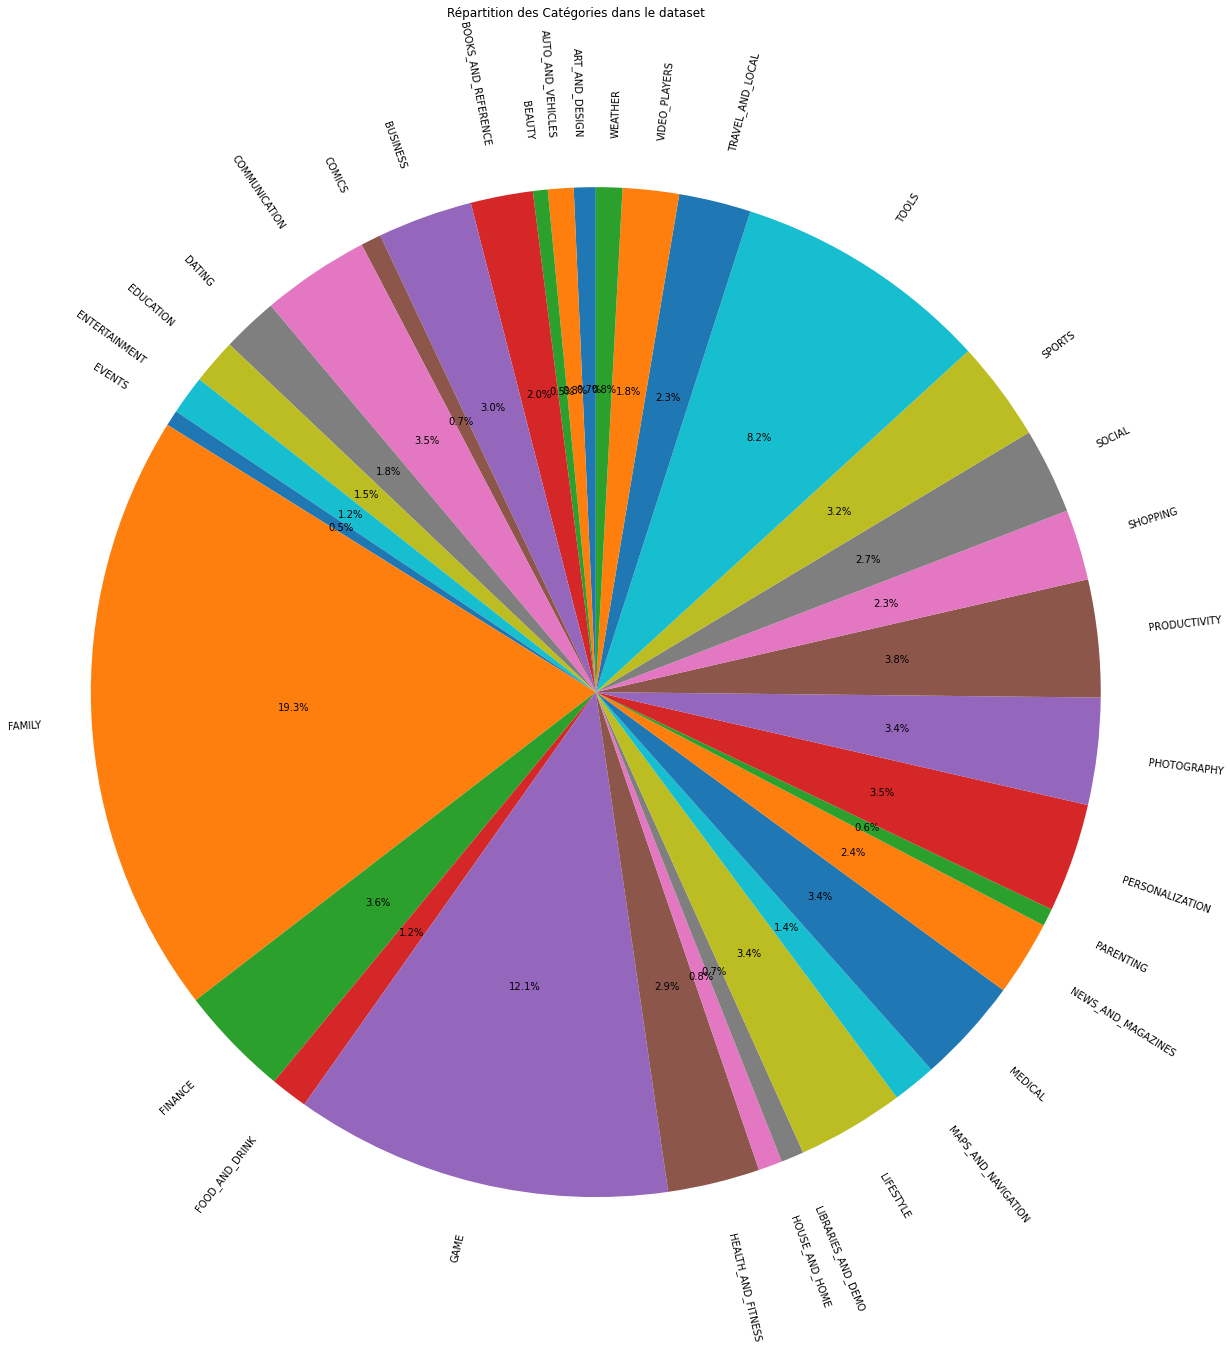

In [24]:
categories = np.unique(gp_store_his.Category)
nb_elem = np.zeros(len(categories))
index = gp_store_his.index.tolist()

ptr = 0     # Le numéro de la catégorie courante

for categ in categories:
    for i in index:
        cat = gp_store_his.loc[i, "Category"]
        if cat == categ:
            nb_elem[ptr] += 1
    ptr += 1

fig, ax = plt.subplots(figsize=(20, 20))
ax.pie(nb_elem, labels=categories, autopct='%1.1f%%', startangle=90, rotatelabels=270)
ax.axis('equal')
fig.suptitle("Répartition des Catégories dans le dataset")
plt.show()

Puis on s'attaque au coeur du problème.

In [25]:
# Dans les calculs suivants, 1 représentera 1000 afin d'éviter des problèmes de représentation des entiers.

categories = np.unique(gp_store_his.Category)

x = np.array([i for i in range(len(categories))])
inst = []                                                   # contiendra le nombre médian de téléchargements dans la catégorie
nbInst_tot = 0                                              # Le nombre total de téléchargements

index = gp_store_his.index.tolist()
for categ in categories:
    inst.append([])
    for i in index:
        cat = gp_store_his.loc[i, "Category"]
        if cat == categ:
            installs = gp_store_his.loc[i, "Installs"]
            inst[-1].append(get_installs(installs) / 1000)
    inst[-1] = np.sum(np.array(inst[-1]))
    nbInst_tot += inst[-1]

for i in range(len(inst)):
    inst[i] = inst[i] / (nbInst_tot) * 100

Text(0.5, 1.0, 'Pourcentage du nombre total de téléchargements par catégorie')

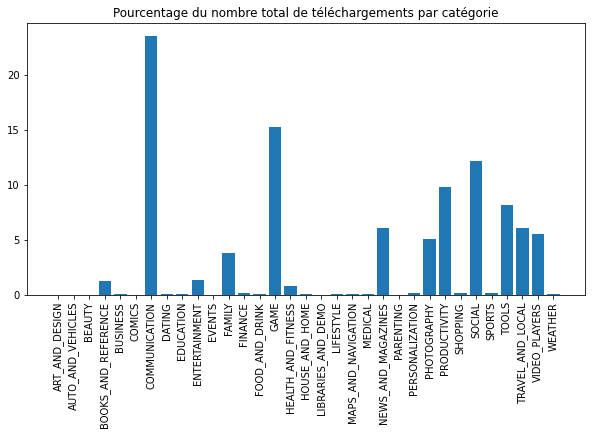

In [26]:
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(x, inst)
plt.xticks(x, categories, rotation=90)
plt.title("Pourcentage du nombre total de téléchargements par catégorie")

** Analyse des données : **

Quatre catégories ressortent pour la part des téléchargements qu'elles occupent : 

* Communication
* Game
* Social
* Productivity

Or, à part les applications de Jeux qui représentent 12% des applications du dataset, la part des applications appartenant aux autres catégories est assez faible. On peut donc s'attendre à ce que, dans ces catégories, on trouve peu d'applications, mais que ces applications soient souvent des géants du domaine : Facebook, Twitter, Whatsapp...

La concurrence ne se fera donc pas en termes de nombre de concurrents, mais en termes d'innovation et d'ajout de fonctionnalités inédites.

## C) Deuxième expérience

Parmi les applications vérifiant les critères de catégorie précédemment trouvés, demandons-nous s'il est possible d'extraire des critères permettant à notre application d'obtenir au moins 4 étoiles.

In [27]:
# On filtre nos données avec les critères trouvés précédemment

filter1 = gp_store_his["Category"] == "COMMUNICATION" 
filter2 = gp_store_his["Category"] == "GAME" 
filter3 = gp_store_his["Category"] == "SOCIAL" 
filter4 = gp_store_his["Category"] == "PRODUCTIVITY"

gp_store_his = gp_store_his[filter1 | filter2 | filter3| filter4]

### Impact du nombre de commentaires


In [28]:
categories = np.unique(gp_store_his.Reviews)
repartition = np.zeros(len(categories))             # Pour obtenir la proportion de chaque catégorie dans le dataset

x = np.array([i for i in range(len(categories))])
four_stars_plus = np.zeros(len(categories))          # contiendra le nombre d'entrées de chaque catégorie ayant au moins un rating de 4 étoiles

index = gp_store_his.index.tolist()
cpt = 0                                              # Le numéro de la catégorie courante
for categ in categories:
    cpt_cat = 0                                      # Compteur du nombre d'éléments de la catégorie courante
    for i in index:
        cat = gp_store_his.loc[i, 'Reviews']
        rating = gp_store_his.loc[i, 'Rating'] 
        if cat == categ:
            cpt_cat += 1
            repartition[cpt] += 1
            if rating >= 4.5:
                four_stars_plus[cpt] += 1
    four_stars_plus[cpt] = (four_stars_plus[cpt] / cpt_cat) * 100           # On se ramène à un pourcentage
    cpt += 1

Text(0.5, 1.0, "Pourcentage du nombre d'applications ayant au moins 4.5 étoiles au sein de leur catégorie")

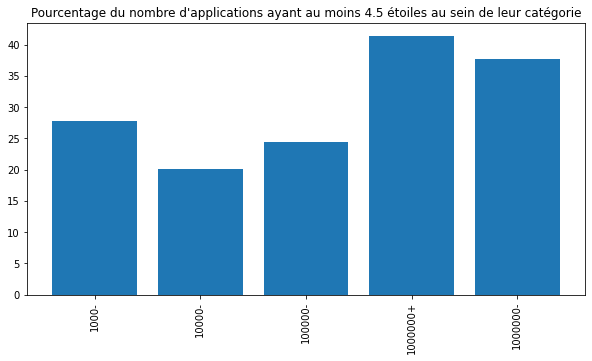

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.bar(x, four_stars_plus)
plt.xticks(x, categories, rotation=90)
plt.title("Pourcentage du nombre d'applications ayant au moins 4.5 étoiles au sein de leur catégorie")

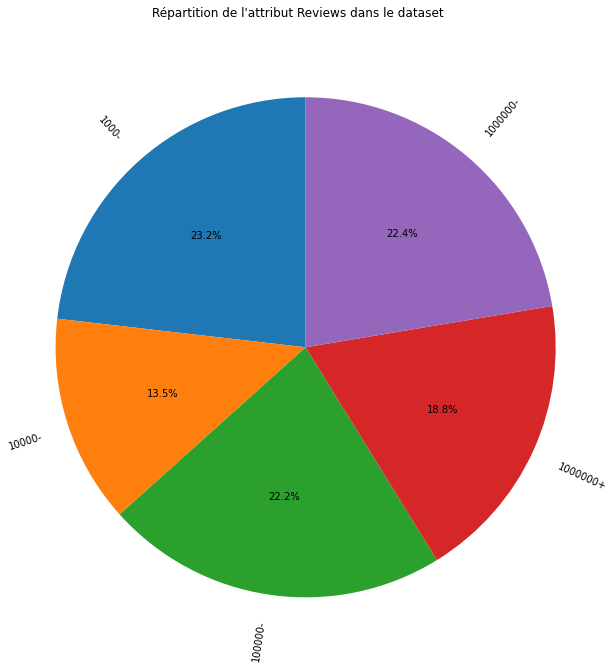

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(repartition, labels=categories, autopct='%1.1f%%', startangle=90, rotatelabels=270)
ax.axis('equal')
fig.suptitle("Répartition de l'attribut Reviews dans le dataset")
plt.show()

** Analyse des données : **

On peut en premier lieu voir que la répartition du nombre d'applications entre les différentes classes est assez homogène.

Puis à partir de l'histogramme, on peut voir que pour obtenir environ 40% de chances d'avoir au minimum la note de 4.5 étoiles, il faut que le nombre de commentaires soit supérieur à 100.000. Il faudra donc définir une stratégie publicitaire permettant d'inciter les utilisateurs à commenter l'application.

### Impact de la taille sur la note

In [31]:
categories = np.unique(gp_store_his.Size)
repartition = np.zeros(len(categories))             # Pour obtenir la proportion de chaque catégorie dans le dataset

x = np.array([i for i in range(len(categories))])
four_stars_plus = np.zeros(len(categories))          # contiendra le nombre d'entrées de chaque catégorie ayant au moins un rating de 4 étoiles

cpt = 0                                              # Le numéro de la catégorie courante
for categ in categories:
    cpt_cat = 0                                      # Compteur du nombre d'éléments de la catégorie courante
    for i in index:
        cat = gp_store_his.loc[i, 'Size']
        rating = gp_store_his.loc[i, 'Rating'] 
        if cat == categ:
            cpt_cat += 1
            repartition[cpt] += 1
            if rating >= 4.5:
                four_stars_plus[cpt] += 1
    four_stars_plus[cpt] = (four_stars_plus[cpt] / cpt_cat) * 100           # On se ramène à un pourcentage
    cpt += 1

Text(0.5, 1.0, "Pourcentage du nombre d'applications ayant au moins 4.5 étoiles au sein de leur catégorie")

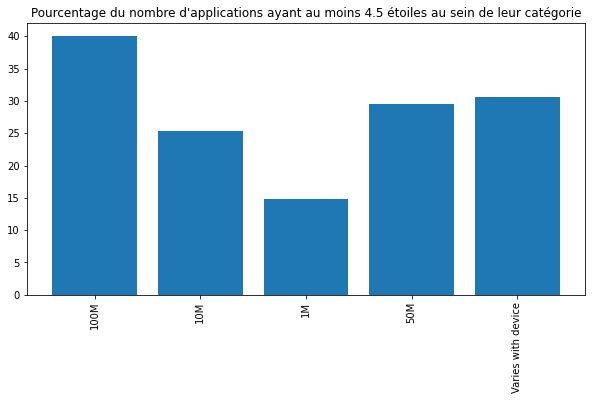

In [32]:
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(x, four_stars_plus)
plt.xticks(x, categories, rotation=90)
plt.title("Pourcentage du nombre d'applications ayant au moins 4.5 étoiles au sein de leur catégorie")

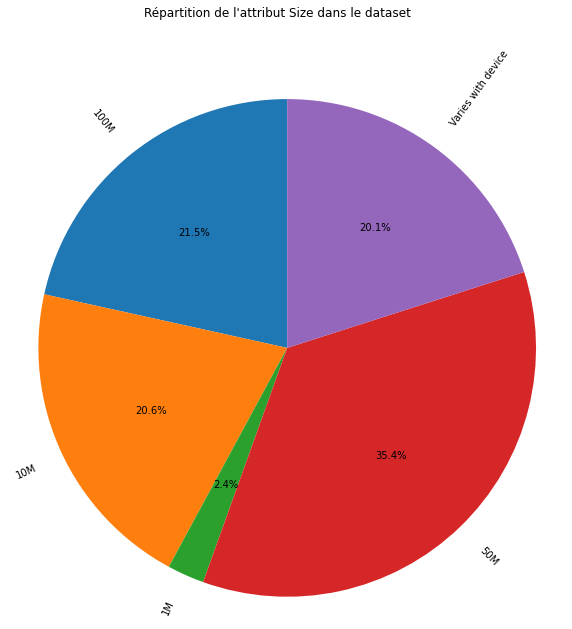

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(repartition, labels=categories, autopct='%1.1f%%', startangle=90, rotatelabels=270)
ax.axis('equal')
fig.suptitle("Répartition de l'attribut Size dans le dataset")
plt.show()

** Analyse des données : **

Gâce au pie-chart, on peut voir que la tendance est d'avoir une application dont la taille est comprise entre 50 et 100 Mo.

L'histogramme nous indique ensuite que plus l'application est lourde, plus elle a de chances d'obtenir une note d'au moins 4.5 étoiles.
Cela peut s'expliquer par le fait que plus l'application est lourde, plus elle est susceptible d'être complète, de contenir plus de fonctionnalités que ces concurrentes.

### Impact de la politique commerciale sur la note

In [34]:
categories = np.unique(gp_store_his.Type)
repartition = np.zeros(len(categories))             # Pour obtenir la proportion de chaque catégorie dans le dataset

x = np.array([i for i in range(len(categories))])
four_stars_plus = np.zeros(len(categories))          # contiendra le nombre d'entrées de chaque catégorie ayant au moins un rating de 4 étoiles

cpt = 0                                              # Le numéro de la catégorie courante
for categ in categories:
    cpt_cat = 0                                      # Compteur du nombre d'éléments de la catégorie courante
    for i in index:
        cat = gp_store_his.loc[i, 'Type']
        rating = gp_store_his.loc[i, 'Rating'] 
        if cat == categ:
            cpt_cat += 1
            repartition[cpt] += 1
            if rating >= 4.5:
                four_stars_plus[cpt] += 1
    four_stars_plus[cpt] = (four_stars_plus[cpt] / cpt_cat) * 100           # On se ramène à un pourcentage
    cpt += 1

Text(0.5, 1.0, "Pourcentage du nombre d'applications ayant au moins 4.5 étoiles au sein de leur catégorie")

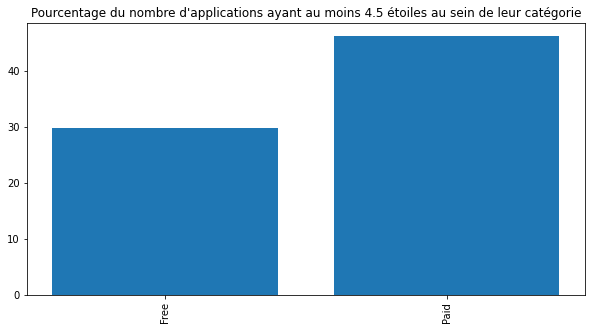

In [35]:
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(x, four_stars_plus)
plt.xticks(x, categories, rotation=90)
plt.title("Pourcentage du nombre d'applications ayant au moins 4.5 étoiles au sein de leur catégorie")

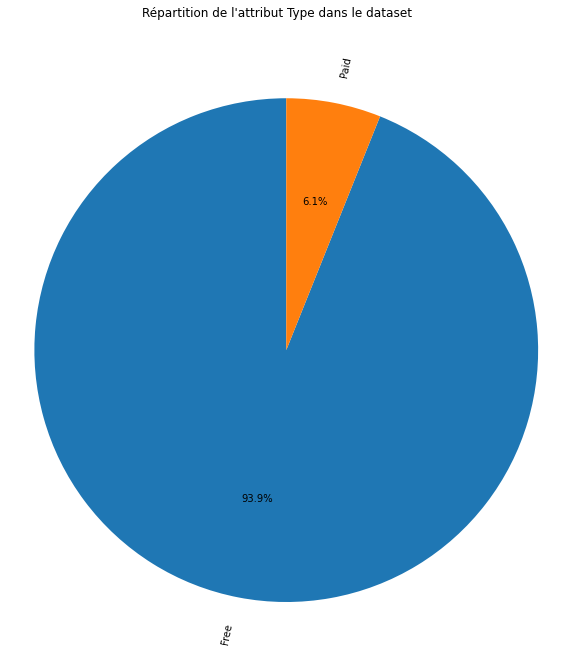

In [36]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(repartition, labels=categories, autopct='%1.1f%%', startangle=90, rotatelabels=270)
ax.axis('equal')
fig.suptitle("Répartition de l'attribut Type dans le dataset")
plt.show()

** Analyse des données : **

La tendance majoritaire est clairement de fournir une application gratuite. Celle-ci sera alors financée probablement par la publicité ou la vente des données personnelles de l'utilisateur.

En revanche, on peut remarquer qu'au sein de la population des applications payantes la probabilité d'avoir une application avec une meilleure note est plus importante, ce qui peut s'expliquer par le fait que la population de ces applications est nettement plus faible mais peut-être également par le fait qu'une application payante a le devoir implicite de fournir plus de fonctionnalités ou d'être de meilleure qualité.

### Impact de la catégorie d'âge de l'application sur la note

In [37]:
categories = np.unique(gp_store_his["Content Rating"])
repartition = np.zeros(len(categories))             # Pour obtenir la proportion de chaque catégorie dans le dataset

x = np.array([i for i in range(len(categories))])
four_stars_plus = np.zeros(len(categories))          # contiendra le nombre d'entrées de chaque catégorie ayant au moins un rating de 4 étoiles

cpt = 0                                              # Le numéro de la catégorie courante
for categ in categories:
    cpt_cat = 0                                      # Compteur du nombre d'éléments de la catégorie courante
    for i in index:
        cat = gp_store_his.loc[i, 'Content Rating']
        rating = gp_store_his.loc[i, 'Rating'] 
        if cat == categ:
            cpt_cat += 1
            repartition[cpt] += 1
            if rating >= 4.5:
                four_stars_plus[cpt] += 1
    four_stars_plus[cpt] = (four_stars_plus[cpt] / cpt_cat) * 100           # On se ramène à un pourcentage
    cpt += 1

Text(0.5, 1.0, "Pourcentage du nombre d'applications ayant au moins 4.5 étoiles au sein de leur catégorie")

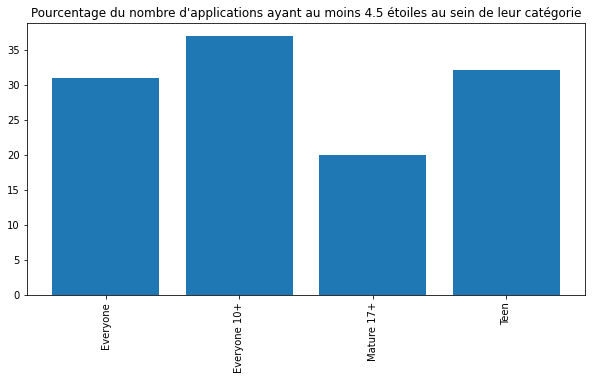

In [38]:
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(x, four_stars_plus)
plt.xticks(x, categories, rotation=90)
plt.title("Pourcentage du nombre d'applications ayant au moins 4.5 étoiles au sein de leur catégorie")

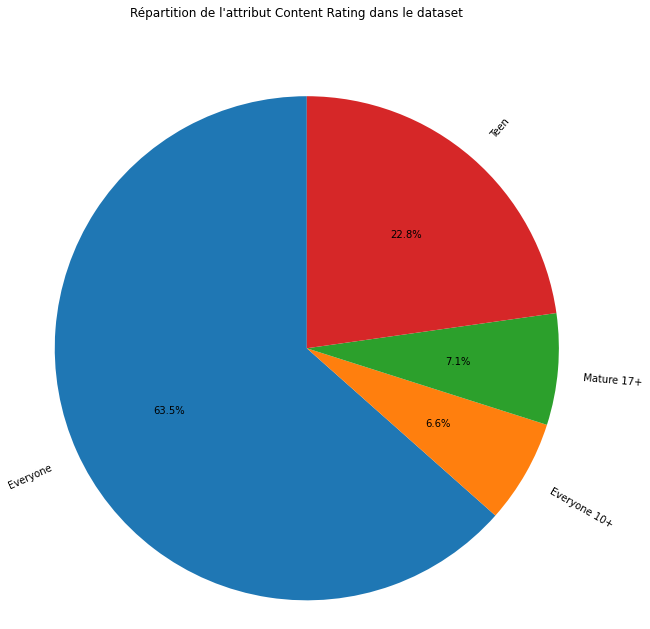

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(repartition, labels=categories, autopct='%1.1f%%', startangle=90, rotatelabels=270)
ax.axis('equal')
fig.suptitle("Répartition de l'attribut Content Rating dans le dataset")
plt.show()

** Analyse des données : **

Ici clairement, le meilleur choix à faire est de concevoir une application destinée à tous les âges ou au moins aux adolescents. Ici la probabilité d'avoir une bonne note est plus élevée pour la catégorie "Everyone 10+", mais cela s'explique probablement par le fait que la population de ces applications est très restreinte par rapport au reste.

## Troisième expérience

Nous allons à présent considérer que notre application est destinée à tous ou destinée aux adolescents et nous allons choisir de rendre cette application payante (on n'aime ni la publicité ni la vente des données de ses utilisateurs).

On va étudier les prix pratiqués et leur impact sur la note et le nombre de téléchargements pour être sûr d'avoir le meilleur prix.

On commence par filtrer le dataset avec les critères choisis précédemment.

In [40]:
filter1 = gp_store_his["Type"] == "Paid"
filter2 = gp_store_his["Content Rating"] == "Everyone"
filter3 = gp_store_his["Content Rating"] == 'Teen'
filter4 = gp_store_his["Size"] == '100M'
filter5 = gp_store_his["Size"] == '50M'
filter6 = gp_store_his["Size"] == 'Varies with device'

gp_store_his = gp_store_his[filter1 & (filter2 | filter3) & (filter4 | filter5 | filter6)]

### Impact du prix sur la note

In [41]:
categories = [val for val in np.unique(gp_store_his.Price) if val != '0']
repartition = np.zeros(len(categories))             # Pour obtenir la proportion de chaque catégorie dans le dataset

x = np.array([i for i in range(len(categories))])
four_stars_plus = np.zeros(len(categories))          # contiendra le nombre d'entrées de chaque catégorie ayant au moins un rating de 4 étoiles

index = gp_store_his.index.tolist()
cpt = 0                                              # Le numéro de la catégorie courante
for categ in categories:
    cpt_cat = 0                                      # Compteur du nombre d'éléments de la catégorie courante
    for i in index:
        cat = gp_store_his.loc[i, 'Price']
        rating = gp_store_his.loc[i, 'Rating'] 
        if cat == categ:
            cpt_cat += 1
            repartition[cpt] += 1
            if rating >= 4.5:
                four_stars_plus[cpt] += 1
    four_stars_plus[cpt] = (four_stars_plus[cpt] / cpt_cat) * 100           # On se ramène à un pourcentage
    cpt += 1

Text(0.5, 1.0, "Pourcentage du nombre d'applications ayant au moins 4.5 étoiles au sein de leur catégorie")

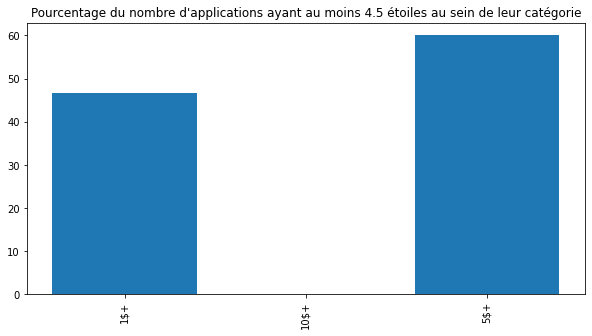

In [42]:
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(x, four_stars_plus)
plt.xticks(x, categories, rotation=90)
plt.title("Pourcentage du nombre d'applications ayant au moins 4.5 étoiles au sein de leur catégorie")

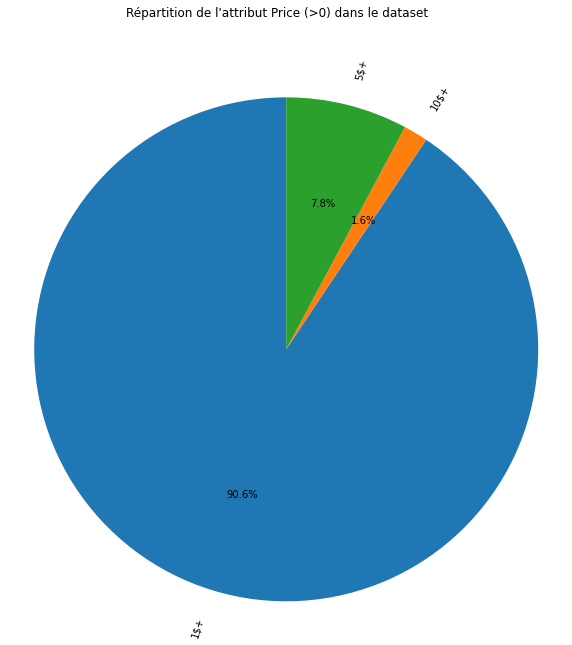

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(repartition, labels=categories, autopct='%1.1f%%', startangle=90, rotatelabels=270)
ax.axis('equal')
fig.suptitle("Répartition de l'attribut Price (>0) dans le dataset")
plt.show()

** Analyse des données : **

Étant donnée la répartition des tranches de prix, il semble préférable d'avoir un prix compris entre 1\$ et 5\$.

### Impact du prix sur le nombre de téléchargements

In [44]:
categories = [val for val in np.unique(gp_store_his.Price) if val != '0']
repartitions = np.zeros(len(np.unique(gp_store_his.Installs)))

x = np.array([i for i in range(len(categories))])
inst = np.zeros(len(categories))          # contiendra le nombre d'entrées de chaque catégorie ayant au moins un rating de 4 étoiles

cpt = 0                                   # Le numéro de la catégorie courante
for categ in categories:
    cpt_cat = 0                           # Compteur du nombre d'éléments de la catégorie courante
    for i in index:
        cat = gp_store_his.loc[i, 'Price'] 
        if cat == categ:

            installs = get_installs(gp_store_his.loc[i, 'Installs']) / 1000
            if installs == 0.001:
                repartitions[0] += 1
            elif installs == 1:
                repartitions[1] += 1
            elif installs == 10:
                repartitions[2] += 1
            elif installs == 100:
                repartitions[3] += 1
            elif installs == 1000:
                repartitions[4] += 1
            elif installs == 500000:
                repartitions[5] += 1
            else:
                repartitions[6] += 1
            inst[cpt] += installs
    cpt += 1

Text(0.5, 1.0, 'Nombre cumulé de téléchargements en milliers')

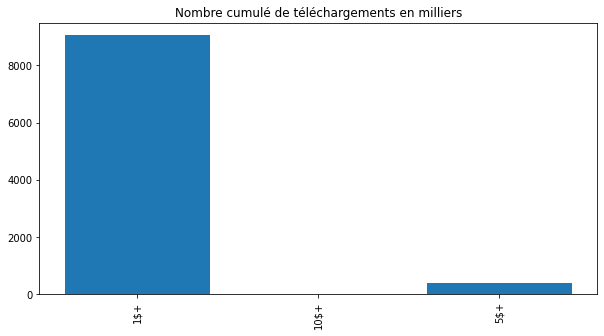

In [45]:
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(x, inst)
plt.xticks(x, categories, rotation=90)
plt.title("Nombre cumulé de téléchargements en milliers")

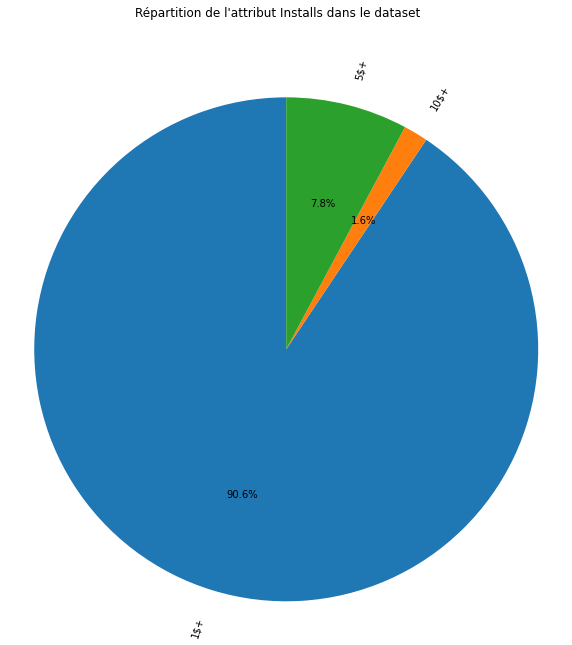

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(repartition, labels=categories, autopct='%1.1f%%', startangle=90, rotatelabels=270)
ax.axis('equal')
fig.suptitle("Répartition de l'attribut Installs dans le dataset")
plt.show()

** Analyse des données : **

On confirme l'intuition précédente : le prix idéal pour notre application est compris entre 1\$ et 5\$. Ainsi, nous avons plus de chances d'obtenir une note d'au moins 4 étoiles et de maintenir un nombre de téléchargements potentiels élevé.

### D) Quatrième expérience

Nous avons extrait des expériences précédentes des critères que nous jugeons importants pour le succès de notre application. À présent, nous allons entraîner notre classifieur ADALINE sur le dataset préparé dans la partie 3. Nous allons ensuite essayer de prédire si les notes d'applications vérifiant les propriétés trouvées sont bien supérieures à 4 étoiles.

In [48]:
gp_store["Rating"] = gp_store["Rating"].astype(int)
gp_store.head(5)
gp_store_test1 = copy.deepcopy(gp_store)

In [49]:
# Conversion du dataset en arrays
colonnes = [nom for nom in gp_store_test1.columns if nom != "Rating"]
data_desc = np.array(gp_store_test1[colonnes])
data_lab = np.array(gp_store_test1["Rating"])

In [50]:
index = np.random.permutation(len(data_desc)) # mélange des index
Xm = data_desc[index]
Ym = data_lab[index]
niter = 10
eps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]


for epsilon in eps:
    perf = []
    for i in range(niter):
        Xapp,Yapp,Xtest,Ytest = ut.crossval_strat(Xm, Ym, niter, i)
        adal = cl.ClassifierADALINE(len(data_desc[0]), epsilon)
        adal.train(Xapp, Yapp)
        perf.append(adal.accuracy(Xtest, Ytest))
    print("Epsilon = ", epsilon, "\nPerf : ", perf, "\n")


Epsilon =  0.001 
Perf :  [0.6580427446569179, 0.7457817772778402, 0.6321709786276716, 0.6479190101237345, 0.44431946006749157, 0.4184476940382452, 0.5957207207207207, 0.6632882882882883, 0.7882882882882883, 0.4752252252252252] 

Epsilon =  0.0001 
Perf :  [0.7525309336332958, 0.7469066366704162, 0.7412823397075365, 0.7750281214848144, 0.766029246344207, 0.7694038245219348, 0.7297297297297297, 0.7927927927927928, 0.27815315315315314, 0.7353603603603603] 

Epsilon =  1e-05 
Perf :  [0.8008998875140607, 0.7750281214848144, 0.7784026996625422, 0.7682789651293588, 0.7750281214848144, 0.7604049493813273, 0.7657657657657657, 0.7927927927927928, 0.7894144144144144, 0.7736486486486487] 

Epsilon =  1e-06 
Perf :  [0.7997750281214848, 0.7671541057367829, 0.7581552305961755, 0.7412823397075365, 0.7716535433070866, 0.7592800899887514, 0.7477477477477478, 0.7668918918918919, 0.7759009009009009, 0.7736486486486487] 

Epsilon =  1e-07 
Perf :  [0.7829021372328459, 0.6467941507311586, 0.7559055118110

Maintenant que nous avons entraîné notre classifieur et que nous avons trouvé son hyperparamètre optimal ($\epsilon = 10^{-5}$), nous créons nos vecteurs correspondant à des applications avec les critères retenus et nous vérifions que nous obtenons bien une note supérieure ou égale à 4 étoiles (classe +1).

Les paramètres fixes choisis sont : 

* Reviews : dans 100.000+
* Taille : 100 Mo
* Type : Paid
* Prix : 4.99$

Les paramètres variants ont pour valeurs possibles :

* Category : COMMUNICATION, GAME, PRODUCTIVITY, SOCIAL
* Content Rating: Everyone, Teen

In [51]:
# Communication - Everyone
app1 = np.array([100, 4.99, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])

# Communication - Teen
app2 = np.array([100, 4.99, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])

# Game - Everyone
app3 = np.array([100, 4.99, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])

# Game - Teen
app4 = np.array([100, 4.99, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 , 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])

# Productivity - Everyone
app5 = np.array([100, 4.99, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])

# Productivity - Teen
app6 = np.array([100, 4.99, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])

# Social - Everyone
app7 = np.array([100, 4.99, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0])

# Social - Teen
app8 = np.array([100, 4.99, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0])

In [53]:
apps = np.array([app1, app2, app3, app4, app5, app6, app7, app8])

adal = cl.ClassifierADALINE(len(data_desc[0]), 1e-5)
adal.train(Xm[0:8000], Ym[0:8000])
print(adal.accuracy(Xm[8000:], Ym[8000:]))

for x in apps:
    print(adal.predict(x))

0.791196388261851
1
1
1
1
1
1
1
1


** Analyse : **
Étant donnés les paramètres choisis, notre classifieur prédit que chacune des applications proposées a effectivement une note supérieure ou égale à 4 étoiles.

## Partie 6 - Analyse et conclusion

Pour conclure sur ce que nous avons trouvé : 

* Pour toucher la plus large audience, les catégories possibles de notre application doivent être : COMMUNICATION, GAME, PRODUCTIVITY, SOCIAL.
* Pour s'assurer une bonne note, il ressort principalement de l'étude que les applications offrant le plus de fonctionnalités (les plus lourdes) sont plus susceptibles d'obtenir une note d'au moins 4 étoiles.
* En outre, notre application doit être au moins destinée à un public jeune, ou bien être une application destinée à tous.
* Enfin, le meilleur prix pour notre application semble être 4.99$.
* Faire parler de l'application en incitant les utilisateurs à laisser des commentaires est également une piste pour garantir une bonne note à l'application.